# **Forecasting a Recession in the USA**
## __Part - 4__: Data Scaling Strategies.

#### __The Story so far__

In the first part of this study I analyzed why recessions are important and how they affect returns in the Equity Market (SP500).The second chapter's focus has been on the creation of the dataset and its EDA. In the third part I tackled the issue of dimensionality reduction by shortlisting two feature selection and extraction strategies (SelectFromModel with RandomForest and PCA) to be used later on in the construction of a ML pipeline. In this chapter I will explore data scaling strategies. 
#### _Index:_<a name="tol"></a>

4.1 [Dimensionality Reduction - Overview and Goals;](#DS)  
4.2 [Data Scaling - Example on two features](#ex)       
4.3 [Data Scaling - Testing the alternatives;](#test)  
4.4 [Conclustion](#conc1)

## 4.1 Data Scaling - Overview and Goals<a name="DS"></a>

Some ML algorithm performances can be affected by the magnitude of the data they are fed with. If a feature's variance is orders of magnitude more than the variance of other features, that particular feature might dominate other features in the dataset. Most of the times dataset will contain features highly varying in magnitudes, units, and range. But since most of the machine learning algorithms use Euclidian distance between two data points in their computations, this is a problem.
If left alone, these algorithms only take in the magnitude of features neglecting the units. The results would vary greatly between different units. For instance in the dataset, ISM-PMI has an average above 50 and most of the time scores values between 40 and 60, while all the features calculated as percentage change average close to zero and seldomly exceed +/-5%. The features with high magnitudes will weigh in a lot more in the distance calculations than features with low magnitudes. To suppress this effect, I need to bring all features to the same level of magnitudes. This can be achieved by scaling. In order to overcome these shortcoming, different approaches to data scaling provided in SciKit-Learn are tested:

* StandardScaler;
* QuantileTransformer-Uniform;
* QuantileTransformer-Normal;
* PowerTransformer;
* MinMaxScaler; and
* RobustScaler.

as a general reminder, a not exaustive (!) list of some the ML models whose performance is affected by data scaling is the following:

* linear and logistic regression;
* nearest neighbors;
* neural networks;
* support vector machines with radial bias kernel functions; and
* principal components analysis (PCA).

In particular, since PCA is both one of the dimensionality reduction tool I selected to apply in the analysis and belongs to the above list, a proper scaling of the data is a necessary step to fine tune the ML model.  

__Goal__: The main aim of this chapter is to understand the effect of different scaling process on models generalization performances in classifing recession/expansion periods in US economy. The idea is to shortlist a set of strategies to be nested into a pipeline later on in the analysis.

## 4.2 Data Scaling - Example on two features<a name="ex"></a>

In order to appreciate how scaling can improve models' performance, I first carry out an example by extracting only two features from the original dataset using the PCA.   
  
I implement the following steps:  
+ After importing all the libraries that will be used in this chapter and the training dataset, I split the data between a train and validation subset (As a reminder I already split the data between training and test set, where the latter will be used only at the very end to evaluate the generalization properties of the selected models). The validation set is equal to 30% of the overall training dataset.

In [85]:
# Import all the required scalers 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
# import all the required models
# Import Models Libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier,BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression,SGDClassifier,RidgeClassifier
# generic libraries
import pandas as pd
import numpy as np
import mglearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("white")
np.set_printoptions(precision=4)

In [8]:
# import dataset
path_X_train='Data_from_prev_steps/X_train_data.csv'
path_y_train='Data_from_prev_steps/y_train_data.csv'

X_train=pd.read_csv(path_X_train, parse_dates=['Date']) #, parse_dates=['Unnamed: 0']
y_train=pd.read_csv(path_y_train, parse_dates=['Unnamed: 0']) #
#X_train.rename(columns ={"Unnamed: 0":"Date"},inplace=True)
y_train.rename(columns ={"Unnamed: 0":"Date"},inplace=True)
X_train.set_index("Date",inplace=True)
y_train.set_index("Date",inplace=True)
y_train=y_train.values.ravel()

# Split data and check the size:
Xtrain,Xval,ytrain,yval=train_test_split(X_train,y_train,random_state=17031978,test_size=0.3,stratify=y_train)
print('Xtrain size: {}; ytrain size: {}'.format(Xtrain.shape,ytrain.shape))
print('Xval size: {}; yval size: {}'.format(Xval.shape,yval.shape))

Xtrain size: (471, 42); ytrain size: (471,)
Xval size: (202, 42); yval size: (202,)


+ I create a new features dataframe by fitting and transforming the MinMaxScaler on the training sub-set. Then the PCA is used to extract two new features from the unscaled dataset and two new features from the scaled one. 

In [12]:
# Initiate and train MinMaxScaler:
scaler=MinMaxScaler()
scaler.fit(Xtrain)
Xt_s=scaler.transform(Xtrain)
Xv_s=scaler.transform(Xval)
# Initiate PCA
pca=PCA(2)
# Extract 2 features from the unscaled dateset
pca_noscal=pca.fit(Xtrain,ytrain)
Xt_pca=pca_noscal.transform(Xtrain)
Xv_pca=pca_noscal.transform(Xval)
# Extract 2 features from the scaled dateset
pca_scaled=pca.fit(Xt_s,ytrain)
Xt_s_pca=pca_scaled.transform(Xt_s)
Xv_s_pca=pca_scaled.transform(Xv_s)

print('Shape of PCA Features extracted from Unscaled Dataset: Training: {}, Validation: {}'.format(Xt_pca.shape,Xv_pca.shape))
print('Shape of PCA Features extracted from Scaled Dataset: Training: {}, Validation: {}'.format(Xt_s_pca.shape,Xv_s_pca.shape))

Shape of PCA Features extracted from Unscaled Dataset: Training: (471, 2), Validation: (202, 2)
Shape of PCA Features extracted from Scaled Dataset: Training: (471, 2), Validation: (202, 2)


+ A first impression on how scaling might affect the analysis comes from the sheer visualization of a scatter plot of the two sets of features extracted from the scaled and the unscaled data. The two sets of features differ massively in terms the scale and relative location of recession and expansion observation. Now I take the analysis a step forward by training a KNN-classifier on the two set of data. 

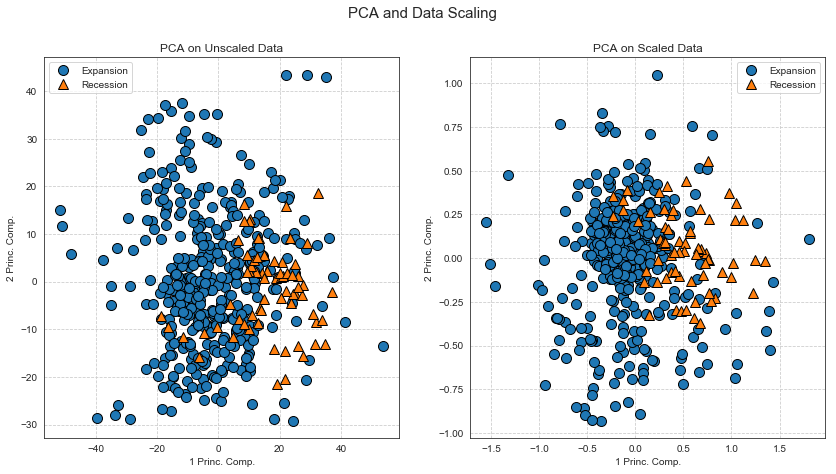

In [97]:
fig, (ax1,ax2)=plt.subplots(1,2, figsize=(14,7))
mglearn.discrete_scatter(Xt_pca[:, 0], Xt_pca[:, 1], ytrain, ax=ax1)
ax1.set_xlabel("1 Princ. Comp.")
ax1.set_ylabel("2 Princ. Comp.")
ax1.grid(linestyle='--')
ax1.set_title('PCA on Unscaled Data')
ax1.legend(["Expansion", "Recession"]);
mglearn.discrete_scatter(Xt_s_pca[:, 0], Xt_s_pca[:, 1], ytrain, ax=ax2)
ax2.set_xlabel("1 Princ. Comp.")
ax2.set_ylabel("2 Princ. Comp.")
ax2.legend(["Expansion", "Recession"])
ax2.grid(linestyle='--')
ax2.set_title('PCA on Scaled Data')
fig.suptitle("PCA and Data Scaling",fontsize=15);
fig.savefig('Pictures/PCAScaledandunscaled.png',dpi=75,bbox_inches='tight');

+ First I train a KNN-classifier with 6 neighbours on the two features derived from the unscaled dataset. Then the same model is fitted on the PCA features extraced from the scaled data. The results are reported in the two graphs below. As the scores show, working on the scaled data improved the validation score of the model of a rounded 4%, from 85.1% to 89.1%. Despite being less relevant, also the performance on the training dataset slightly improved of 2.1%.

Training Score not-Scaled Features: 0.890
Validation Score not-Scaled Features: 0.876



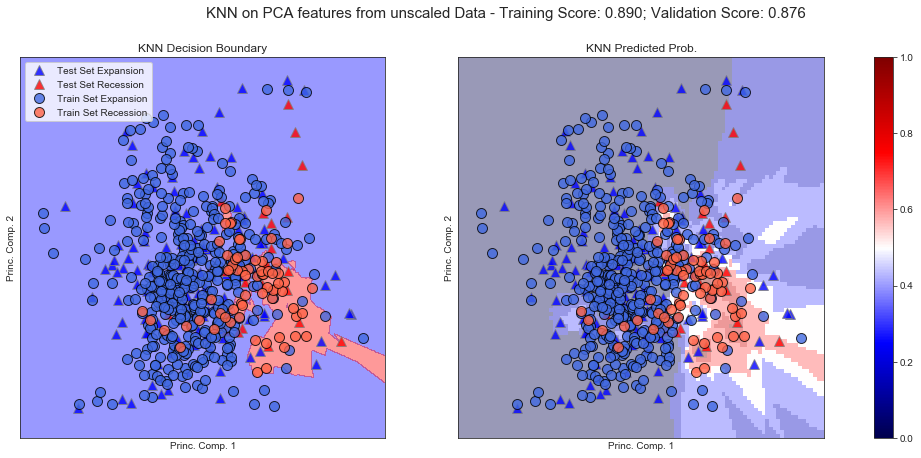

In [96]:
clf =KNeighborsClassifier(n_neighbors=6).fit(Xt_pca, ytrain)#SVC(kernel='linear',C=0.5,random_state=17,probability=True).fit(Xt_pca, ytrain) #SVC(kernel='rbf',C=1,gamma=0.1,random_state=17,probability=True).fit(Xt, ytrain)#KNeighborsClassifier(n_neighbors=7).fit(Xt, ytrain)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
mglearn.tools.plot_2d_separator(clf, Xt_pca, ax=axes[0], alpha=.4, fill=True, cm='seismic')
scores_image = mglearn.tools.plot_2d_scores(clf, Xt_pca, ax=axes[1], alpha=.4, cm='seismic', function='predict_proba')

axes[0].set_title('KNN Decision Boundary')
axes[1].set_title('KNN Predicted Prob.')
fig.suptitle("KNN on PCA features from unscaled Data - Training Score: {:.3f}; Validation Score: {:.3f}".format(clf.score(Xt_pca,ytrain),
                                                                                                                clf.score(Xv_pca,yval))
             ,fontsize=15);
for ax in axes:
    # plot training and test points
    mglearn.discrete_scatter(Xv_pca[:, 0], Xv_pca[:, 1], yval,
                             markers='^',c=['blue','red'], ax=ax,alpha=0.8)
    mglearn.discrete_scatter(Xt_pca[:, 0], Xt_pca[:, 1], ytrain,
                             markers='o',c=['royalblue','tomato'], ax=ax,alpha=0.8)
    #ax.set_xlim(-25,25)
    ax.set_xlabel("Princ. Comp. 1")
    ax.set_ylabel("Princ. Comp. 2")
    ax.grid(linestyle='--')



cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["Test Set Expansion", "Test Set Recession", "Train Set Expansion",
                "Train Set Recession"], ncol=1, loc='best');

fig.savefig('Pictures/PCAUnscaled.png',dpi=75,bbox_inches='tight')    
print('Training Score not-Scaled Features: {:.3f}'.format(clf.score(Xt_pca,ytrain)))
print('Validation Score not-Scaled Features: {:.3f}\n'.format(clf.score(Xv_pca,yval)))

Training Score Scaled Features: 0.907
Validation Score Scaled Features: 0.901



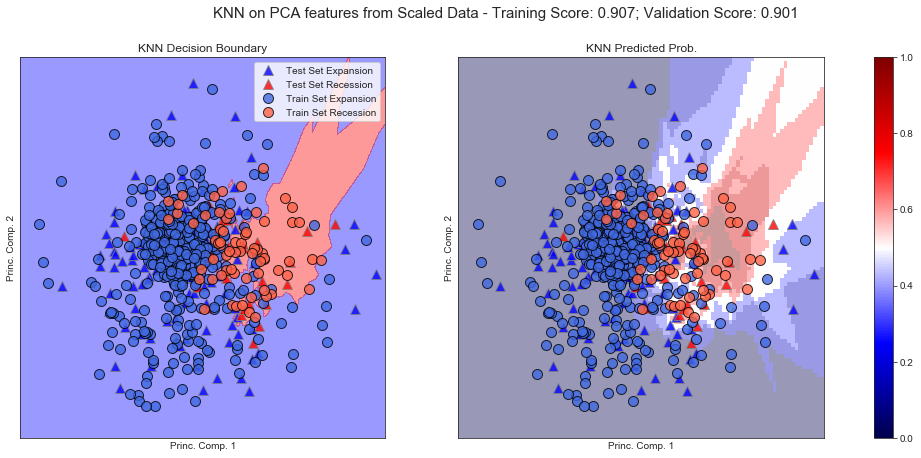

In [99]:
clf =KNeighborsClassifier(n_neighbors=6).fit(Xt_s_pca, ytrain)#LogisticRegression(solver="liblinear", C=1,class_weight='balanced').fit(Xt_s_pca, ytrain)# SVC(kernel='rbf',C=1,gamma=0.1,random_state=17,probability=True).fit(Xt_s, ytrain)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
axes[0].set_title('KNN Decision Boundary')
axes[1].set_title('KNN Predicted Prob.')
fig.suptitle("KNN on PCA features from Scaled Data - Training Score: {:.3f}; Validation Score: {:.3f}".format(clf.score(Xt_s_pca,ytrain),clf.score(Xv_s_pca,yval))
             ,fontsize=15);
    
mglearn.tools.plot_2d_separator(clf, Xt_s_pca, ax=axes[0], alpha=.4, fill=True, cm='seismic')
scores_image = mglearn.tools.plot_2d_scores(clf, Xt_s_pca, ax=axes[1], alpha=.4, cm='seismic',function='predict_proba')#, function='predict_proba'

for ax in axes:
    # plot training and test points
    mglearn.discrete_scatter(Xv_s_pca[:, 0], Xv_s_pca[:, 1], yval,
                             markers='^',c=['blue','red'], ax=ax,alpha=0.8)
    mglearn.discrete_scatter(Xt_s_pca[:, 0], Xt_s_pca[:, 1], ytrain,
                             markers='o',c=['royalblue','tomato'], ax=ax,alpha=0.8)
    ax.set_xlabel("Princ. Comp. 1")
    ax.set_ylabel("Princ. Comp. 2")

cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["Test Set Expansion", "Test Set Recession", "Train Set Expansion",
                "Train Set Recession"], ncol=1, loc='best');
fig.savefig('Pictures/PCAScaled.png',dpi=75,bbox_inches='tight')  
    
print('Training Score Scaled Features: {:.3f}'.format(clf.score(Xt_s_pca,ytrain)))
print('Validation Score Scaled Features: {:.3f}\n'.format(clf.score(Xv_s_pca,yval)))

## 4.3 Data Scaling - Testing the alternatives<a name="test"></a>

The next step is to generalize this analysis by applying a wider ranger of scalers on 16 PCA features. I will test the scalers on a number of ML algoriths in order to generalize as mush as possible the results and to not over-rely on a specific model.

As mentioned before, the set of scaler that will be tested is the following:

1. StandardScaler;
1. QuantileTransformer-Uniform;
1. QuantileTransformer-Normal;
1. PowerTransformer;
1. MinMaxScaler; and
1. RobustScaler.

While these are ML algoriths used:
+ GaussianNaiveBayes;
+ LogisticRegression;
+ KNeighborsClassifier;
+ ExtraTreesClassifier;
+ SVC, kernel='rbf';
+ LinearSVC;
+ Bagging with GaussianNB; and
+ MLPClassifier.

Each of these model is first is trained and its performance tested on the entire unscaled dataset (__"No Scaling - All Features"__ row in the table). Then I try to extract the 16 features using PCA from the unscaled dataset and I train and test the models on them (__"No Scaling - PCA"__). This line should provide an insight on the negative impact of using PCA on un-scaled data and a futher term of comparison for the models in the list. Then the training and the validation dataset are scaled according the six metrix enumerated above. PCA analysis is performed on each of them and 16 features extracted. Each model is then trained and tested on the validation set (all the other rows in the table). The results are reported two tables: one reporting the score on the training dataset and the other, and most important, reporting the score achieved on validation data. Best scores are marked in light blue.

In [16]:
# Create a function for analisys steps:
def datascalinganalysis(scaler,Xt,yt,Xv,yv,feat_select,model,name_scaler=None,name_model=None):    
    scaler = scaler
    scaler.fit(Xt)
    Xt_scaled = scaler.transform(Xt)
    Xv_scaled = scaler.transform(Xv)
    #print(key)
    feat_select.fit(Xt_scaled,yt)
    Xt_m=feat_select.transform(Xt_scaled)
    Xv_m=feat_select.transform(Xv_scaled) 
    mod=model.fit(Xt_m, yt)
    
    c=mod.score(Xt_m, yt)
    d=mod.score(Xv_m, yv)
    
    return [c,d]
# Create a function for analisys steps:
def feat_selection(selector,Xt,yt,Xv,yv,model,title=None,plots=True):
    selector.fit(Xt,yt)
    Xt_m=selector.transform(Xt)
    Xv_m=selector.transform(Xv)
    if plots==True:
        print("Shape of Original Xtrain Dataframe: {}".format(Xt.shape))
        print("Shape of Selected Xtrain Dataframe: {}".format(Xt_m.shape))
        # get the feature filter: Black=in, white=out:
        mask_m=selector.get_support()
        #create a visual rapresetation:
        ticks=list(range(0,Xt.shape[1]+10,10))
        plt.matshow(mask_m.reshape(1,-1),cmap="gray_r")
        plt.xlabel(title)
        plt.xticks((ticks))
        #plt.title(title)
        plt.yticks(());
        path='Pictures/'+str(title)+'.png'
        plt.savefig(path)
    mod=model.fit(Xt_m, yt)
    if plots==True:
        print("Train-Score with only selected features: {:.3f}".format(mod.score(Xt_m, yt)))
        print("Val-Score with only selected features: {:.3f}\n".format(mod.score(Xv_m, yv)))
    ins=mod.score(Xt_m, yt)
    oos=mod.score(Xv_m, yv)
    return [ins,oos]
# DataFrame formatting:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: cornflowerblue' if v else '' for v in is_max]

In [89]:
# Create a Dictionary with all the scaler and option:
scaler_dict={"MinMaxScaler":MinMaxScaler(),
             "StandardScaler":StandardScaler(),
             "RobustScaler":RobustScaler(),
             "QuantileTransformer-Uniform":QuantileTransformer(output_distribution="uniform",n_quantiles=20), 
             "QuantileTransformer-Normal":QuantileTransformer(output_distribution="normal",n_quantiles=20),
             "PowerTransformer-Normal-yeo-johnson":PowerTransformer(method="yeo-johnson")}
model_dict={"NBGauss":GaussianNB(),
            "LogReg":LogisticRegression(solver="liblinear", C=1),
            "KNN":KNeighborsClassifier(n_neighbors=5),
            "ExtraTree":ExtraTreesClassifier(n_estimators=100,max_depth=3, random_state=17),
            "SVC_rbf":SVC(kernel='rbf',C=1,gamma=1,random_state=17),
            "Bagging":BaggingClassifier(base_estimator=GaussianNB(),random_state=17,n_jobs=-1),
            "LinearSVC":LinearSVC(penalty='l2',dual=False,C=1,max_iter=1000),
            "MLP":MLPClassifier(hidden_layer_sizes = (10,4,),max_iter=10000,random_state=17)}

select_feat = PCA(16,whiten=False)
scaler_name=["No Scaling - All Features","No Scaling - PCA"]+[*scaler_dict]
model_name=[*model_dict]

validation_result=pd.DataFrame(index=scaler_name,columns=model_name)
train_result=pd.DataFrame(index=scaler_name,columns=model_name)

for key1 in model_dict:
    print("now working on:",key1)
    # fit model on the whole dataset
    lr=model_dict[key1]
    lr.fit(Xtrain, ytrain)
    validation_result.loc["No Scaling - All Features",key1]=lr.score(Xval, yval)
    train_result.loc["No Scaling - All Features",key1]=lr.score(Xtrain, ytrain)
    # fit model on selected features - no scaling
    [a,b]=feat_selection(select_feat,Xtrain,ytrain,Xval,yval,lr,plots=False)
    validation_result.loc["No Scaling - PCA",key1]=b
    train_result.loc["No Scaling - PCA",key1]=a

    for key in scaler_dict:
        [c,d]=datascalinganalysis(scaler_dict[key],Xtrain,ytrain,Xval,yval,feat_select=select_feat,model=lr,name_scaler=key)
        validation_result.loc[key,key1]=d
        train_result.loc[key,key1]=c

now working on: NBGauss
now working on: LogReg
now working on: KNN
now working on: ExtraTree
now working on: SVC_rbf
now working on: Bagging
now working on: LinearSVC
now working on: MLP


In [90]:
train_result.index.name='Results on the Training Dataset:'
display(train_result.style.format("{:.2%}"))

validation_result.index.name='Results on the Validation Dataset:'
display(validation_result.style.apply(highlight_max).format("{:.2%}"))

,NBGauss,LogReg,KNN,ExtraTree,SVC_rbf,Bagging,LinearSVC,MLP
Results on the Training Dataset:,,,,,,,,
No Scaling - All Features,87.90%,93.42%,94.06%,86.41%,100.00%,88.32%,94.27%,99.36%
No Scaling - PCA,89.60%,88.96%,94.27%,85.56%,100.00%,89.60%,89.38%,98.94%
MinMaxScaler,90.23%,89.81%,95.75%,85.99%,94.48%,89.60%,92.14%,99.36%
StandardScaler,88.96%,93.63%,95.75%,85.56%,100.00%,88.11%,93.42%,99.15%
RobustScaler,87.47%,91.51%,95.75%,85.56%,100.00%,87.47%,91.08%,98.73%
QuantileTransformer-Uniform,91.72%,91.08%,96.82%,85.56%,99.58%,91.72%,92.36%,99.58%
QuantileTransformer-Normal,91.72%,92.14%,96.82%,85.56%,100.00%,92.36%,91.51%,99.36%
PowerTransformer-Normal-yeo-johnson,88.96%,93.63%,95.97%,85.77%,100.00%,89.17%,94.06%,99.79%


,NBGauss,LogReg,KNN,ExtraTree,SVC_rbf,Bagging,LinearSVC,MLP
Results on the Validation Dataset:,,,,,,,,
No Scaling - All Features,85.64%,90.59%,87.13%,85.64%,85.64%,86.63%,90.10%,92.08%
No Scaling - PCA,82.67%,87.62%,87.13%,85.64%,85.64%,82.67%,87.62%,90.10%
MinMaxScaler,86.14%,88.61%,93.07%,86.14%,93.56%,85.15%,88.12%,92.57%
StandardScaler,80.20%,89.11%,93.07%,85.64%,85.64%,82.67%,89.11%,93.07%
RobustScaler,84.16%,89.11%,91.58%,85.64%,85.64%,83.17%,89.11%,91.58%
QuantileTransformer-Uniform,91.09%,91.58%,94.06%,85.64%,96.04%,90.59%,92.57%,95.05%
QuantileTransformer-Normal,89.60%,91.09%,93.07%,85.64%,85.64%,89.60%,90.10%,92.57%
PowerTransformer-Normal-yeo-johnson,82.18%,90.10%,93.07%,85.64%,85.64%,82.18%,90.10%,95.05%


## 4.4 Conclusions<a name="conc1"></a>

The use of a proper scaling strategy in some cases grants a considerable improvement in the model performances on the validation data. The boost is more than 10% for GuassianNaiveBayes model and slightly less than 8% for SVC with linear Kernel. Relevant from a technical standpoint is the fact that model performances with features extracted with PCA from unscaled data, are worse in comparison to those achieved on the whole dataset but in two cases. The Quintile-Transformer scalers seems to perform particularly well, with the MinMaxScaler get the runner-up score. In all the cases the best score is realized among the scaled data. One particular reason for the good performance of QuantileTransformers might be related to one of the hallmarks of the dataset that we highlighted during the EDA: the widespread presence of outliers. QuantileTransformers are robust with regards to outliers and therefore thay are a solid choice in order to scale the dataset. As an alternative metric, MinMaxScaler can be considered. 

To conclude, on the basis of the analysis, in order to scale the dataset we will consider the following two procedures:

* __QuantileTransformer with uniform marginal distribution for the transformed data__; and
* __MinMaxScaler__.